# DMD for SET Data

Date: 07/09/2019

## Creating Dataset for DMD

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD

In [4]:
from sys import maxsize
from numpy import set_printoptions

In [5]:
## Import data set

df = pd.read_csv('SET data archive 3416 cases recd thru end of 03 2019_cleaned_general.csv')
df.head()

,Unnamed: 0,UniqueID,no_intake_question,no_retest1_question,no_retest2_question,SET_program_num,ETO_PROGRAM,SET_admin_num,baseline_type,enroll_SET_type_num,...,Completed_by_CIW,CIW_CLIENT_ID,CIW_INTERVIEW_DATE,CIW_COMPLETED_DATE,CIW1,CIW2,CIW3,CIW4,CIW5,CIW6_COMMENTS
0,3,49866,,,,1,1,1,,,...,999,,,,1.0,4.0,4.0,1.0,3.0,Client's son is helping him to change little b...
1,4,49868,,,,1,1,1,,,...,999,,,,2.0,3.0,4.0,1.0,3.0,Slow progress
2,5,49870,,,,1,1,1,,,...,999,,,,2.0,3.0,3.0,1.0,3.0,She goes there a lot ?home? She is trying to c...
3,8,47002,,,,1,1,1,,,...,999,Southwest 2-23-230-1,9/13/2018,9/13/2018,2.0,3.0,1.0,4.0,0.0,Client has been attending program and is stayi...
4,13,41570,,,,2,2,1,,1,...,999,SSSEARE-0-100-1,,,NaN,NaN,NaN,NaN,NaN,no page 17 completed


In [6]:
df['AGE_1_FB'].value_counts()

17     486
18     455
16     394
15     262
19     258
20     159
21     123
14     117
22     107
23     106
24      84
25      81
26      37
13      27
27      16
30      11
28      11
29       6
12       6
33       5
32       4
999      3
31       3
35       3
36       2
34       1
43       1
42       1
Name: AGE_1_FB, dtype: int64

### List all columns needed for DMD dataset

In [12]:
col_kept = ['UniqueID']
col_kept.extend(df.loc[:,'intake':'retest'].columns.tolist())
col_kept.extend(df.loc[:,'GRYD_Zone_num':'INTERVIEW_DATE_FB'].columns.tolist())
col_kept.extend(df.loc[:,'ENROLLMENT_DATE_1':'SEX_1'].columns.tolist())

In [13]:
#include questions only before family

# S section
# attitudinal and score correctly
que = df.loc[:,'S9':'S10'].columns.tolist()
que.extend(df.loc[:,'S10x':'S11a'].columns.tolist())
que.extend(df.loc[:,'S11b':'S16'].columns.tolist())

# ME,P,C section
# except ME18 all reversed 
que.extend(df.loc[:,'ME17':'ME22_ER'].columns.tolist())

# P22,p23,p26 are not scaled correctly
que.extend(df.loc[:,'P22':'P26'].columns.tolist())
que.extend(df.loc[:,'X18':'X22'].columns.tolist())

In [14]:
print(que)
len(que)

['S9', 'S10', 'S10x', 'S10z', 'S11a', 'S11b', 'S12', 'S13', 'S14', 'S16', 'ME17', 'ME18', 'ME19', 'ME20a', 'ME20b', 'ME20x', 'ME22_ER', 'P22', 'P23', 'P24', 'P25', 'P26', 'X18', 'X19', 'X20', 'X21', 'X22']


27

In [15]:
# create the dataframe for DMD

col_kept.extend(que)
df_que = df.filter(col_kept, axis=1)
df_que.head(40)

,UniqueID,intake,retest,GRYD_Zone_num,INTERVIEW_DATE_FB,ENROLLMENT_DATE_1,AGE_1_FB,SEX_1,S9,S10,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
0,49866,1,777,14,3/15/2019,3/6/2019,22,1,3.0,0.0,...,4.0,4.0,2.0,2.0,5.0,1.0,0.0,1.0,1.0,1.0
1,49868,1,777,14,3/15/2019,3/7/2019,23,1,3.0,0.0,...,4.0,4.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0
2,49870,1,777,14,3/14/2019,3/6/2019,25,2,3.0,0.0,...,5.0,5.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0
3,47002,1,777,23,9/13/2018,9/4/2018,18,2,0.0,0.0,...,3.0,3.0,3.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0
4,41570,1,777,999,10/25/2017,10/6/2017,16,1,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,1.0,0.0,1.0,1.0,0.0
5,42392,1,777,999,1/16/2018,1/8/2018,16,1,2.0,0.0,...,4.0,4.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0
6,43298,1,777,999,5/1/2018,3/14/2018,15,1,4.0,0.0,...,5.0,5.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0
7,45090,1,777,999,5/31/2018,5/22/2018,15,2,3.0,0.0,...,4.0,4.0,4.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0
8,26789,1,777,999,4/15/2016,8/13/2015,17,1,4.0,1.0,...,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1.0,0.0,1.0
9,35390,1,777,999,7/17/2017,10/14/2016,18,1,4.0,0.0,...,4.0,4.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0


## Create dataframe for ID3

In [16]:
df_que['retest'].value_counts()

777    2009
1       643
2       101
3        15
999       1
Name: retest, dtype: int64

In [17]:
# list all people whose ID appear three times

ID_3 = df_que.UniqueID.value_counts()[df_que.UniqueID.value_counts() == 3].index
len(ID_3)

60

In [18]:
df_ID3 = df_que[df_que['UniqueID'].isin(ID_3)]

In [19]:
df_ID3.head()

,UniqueID,intake,retest,GRYD_Zone_num,INTERVIEW_DATE_FB,ENROLLMENT_DATE_1,AGE_1_FB,SEX_1,S9,S10,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
78,35341,777,1,1,3/9/2017,9/27/2016,16,2,2.0,2.0,...,4.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,0.0,0.0
79,35341,1,777,1,9/27/2016,9/27/2016,16,2,2.0,2.0,...,4.0,3.0,3.0,3.0,3.0,1.0,0.0,1.0,1.0,1.0
80,35341,777,2,1,10/26/2017,9/27/2016,18,2,2.0,0.0,...,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,0.0,0.0
452,36470,1,777,5,11/7/2016,11/7/2016,18,1,5.0,4.0,...,5.0,5.0,2.0,1.0,5.0,1.0,0.0,1.0,0.0,0.0
453,36470,777,1,5,4/19/2017,10/31/2016,18,1,5.0,3.0,...,5.0,5.0,2.0,2.0,5.0,1.0,0.0,1.0,0.0,0.0


In [20]:
#sort the dataset according to the interview date group by UniqueID

df_ID3['INTERVIEW_DATE_FB'] = pd.to_datetime(df_ID3['INTERVIEW_DATE_FB'], errors='coerce')
df_ID3 = df_ID3.sort_values(by = ['UniqueID','INTERVIEW_DATE_FB'],ascending=True)
df_ID3.head()

,UniqueID,intake,retest,GRYD_Zone_num,INTERVIEW_DATE_FB,ENROLLMENT_DATE_1,AGE_1_FB,SEX_1,S9,S10,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
1252,28923,1,777,10,2015-11-06,10/29/2015,18,1,3.0,1.0,...,4.0,4.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0
1253,28923,777,1,10,2016-05-10,10/29/2015,19,1,3.0,1.0,...,4.0,4.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,1.0
1251,28923,777,2,10,2017-04-27,10/29/2015,20,1,3.0,0.0,...,5.0,5.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
1436,30669,1,777,12,2016-04-11,3/4/2016,15,2,3.0,3.0,...,4.0,5.0,1.0,2.0,4.0,1.0,0.0,1.0,1.0,1.0
1434,30669,777,1,12,2016-09-06,3/4/2016,15,2,3.0,2.0,...,4.0,4.0,3.0,4.0,4.0,1.0,0.0,1.0,1.0,1.0


In [21]:
# drop the person who does not take intake but take three retests instead 

df_ID3 = df_ID3[df_ID3['UniqueID'] != 39880]

### Take care of the people who have nan values in their reponses

In [22]:
#check how many nan values are there in each column

print(df_ID3[que].isnull().sum())

S9         1
S10        1
S10x       2
S10z       2
S11a       1
S11b       2
S12        0
S13        0
S14        0
S16        0
ME17       0
ME18       0
ME19       0
ME20a      0
ME20b      0
ME20x      0
ME22_ER    0
P22        0
P23        0
P24        0
P25        0
P26        0
X18        1
X19        1
X20        1
X21        1
X22        2
dtype: int64


In [23]:
#list the index for those have null values 

List_index=[]
for col in que:
    List_index.extend(df_ID3[df_ID3[col].isnull()].index.tolist())
List_index

[923,
 923,
 1252,
 923,
 1252,
 923,
 923,
 923,
 2468,
 2107,
 2107,
 2107,
 2107,
 2107,
 1728]

In [24]:
#create a unique list for index list

my_set = set(List_index)
unique_index_list = list(my_set)
unique_index_list

[1728, 2468, 923, 1252, 2107]

In [25]:
#create unique ID_list

ID_list = []
for i in unique_index_list:
        ID_list.append(df_ID3.loc[i,'UniqueID'])
ID_list

[39228, 43237, 41793, 28923, 38198]

In [26]:
#drop these people who have nan values 

for ID in ID_list:
    df_ID3 = df_ID3[df_ID3['UniqueID'] != ID]
df_ID3.shape

(162, 35)

## Create Y1, R1, R2 matrices

In [27]:
# create Y1 matrix 

Y1 = df_ID3[df_ID3['intake'] == 1]
Y1.head()
Y1_MATRIX = Y1[que]
Y1_MATRIX.head(10)

,S9,S10,S10x,S10z,S11a,S11b,S12,S13,S14,S16,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
1436,3.0,3.0,0.0,0.0,0.0,0.0,4.0,5.0,5.0,4.0,...,4.0,5.0,1.0,2.0,4.0,1.0,0.0,1.0,1.0,1.0
2364,1.0,1.0,1.0,1.0,1.0,0.0,4.0,4.0,4.0,4.0,...,3.0,4.0,1.0,2.0,5.0,1.0,1.0,1.0,1.0,1.0
2337,2.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,3.0,4.0,...,5.0,5.0,1.0,2.0,5.0,1.0,0.0,1.0,1.0,0.0
2299,7.0,4.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,3.0,...,3.0,3.0,2.0,2.0,3.0,1.0,1.0,0.0,1.0,0.0
1041,5.0,3.0,1.0,0.0,1.0,0.0,4.0,4.0,5.0,3.0,...,5.0,5.0,2.0,3.0,5.0,1.0,0.0,1.0,1.0,1.0
1035,2.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,4.0,2.0,...,5.0,5.0,2.0,2.0,4.0,1.0,1.0,1.0,0.0,0.0
2116,3.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,2.0,3.0,...,4.0,4.0,5.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0
2119,3.0,1.0,1.0,0.0,0.0,0.0,2.0,3.0,3.0,4.0,...,5.0,4.0,3.0,4.0,2.0,1.0,0.0,1.0,1.0,1.0
1483,4.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,4.0,1.0,...,2.0,2.0,5.0,4.0,2.0,1.0,1.0,1.0,0.0,1.0
2129,3.0,2.0,1.0,1.0,0.0,0.0,3.0,4.0,4.0,3.0,...,4.0,5.0,3.0,5.0,3.0,1.0,1.0,0.0,0.0,0.0


In [28]:
#create R1 matrxi

R1 = df_ID3[df_ID3['retest'] == 1]
R1.head()
R1_MATRIX = R1[que]
R1_MATRIX.head()

,S9,S10,S10x,S10z,S11a,S11b,S12,S13,S14,S16,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
1434,3.0,2.0,0.0,0.0,0.0,0.0,3.0,5.0,5.0,5.0,...,4.0,4.0,3.0,4.0,4.0,1.0,0.0,1.0,1.0,1.0
2363,1.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,3.0,4.0,...,3.0,2.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0
2336,2.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,2.0,2.0,...,5.0,5.0,2.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0
2300,2.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,3.0,...,3.0,4.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0
1039,7.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,...,4.0,5.0,2.0,2.0,4.0,1.0,0.0,1.0,1.0,0.0


In [29]:
#create R2 matrix

R2 = df_ID3[df_ID3['retest'] == 2]
R2.head()
R2_MATRIX = R2[que]
R2_MATRIX.head()

,S9,S10,S10x,S10z,S11a,S11b,S12,S13,S14,S16,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
1435,3.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,4.0,...,3.0,4.0,3.0,4.0,3.0,1.0,0.0,1.0,0.0,1.0
2362,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,4.0,4.0,...,4.0,3.0,3.0,2.0,5.0,1.0,0.0,0.0,0.0,1.0
2335,4.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,4.0,4.0,...,5.0,5.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0
2301,2.0,0.0,1.0,0.0,1.0,1.0,2.0,3.0,2.0,2.0,...,4.0,5.0,2.0,3.0,4.0,1.0,0.0,0.0,0.0,0.0
1040,7.0,2.0,1.0,0.0,0.0,0.0,4.0,4.0,4.0,3.0,...,4.0,5.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,0.0


## DMD

In [30]:
U_Y1,Sig_Y1,V_Y1=np.linalg.svd(Y1_MATRIX, full_matrices=False)    
U_Y1_T=U_Y1.conjugate().transpose()
V_Y1_T=V_Y1.conjugate().transpose()
Sig_inv_Y1=np.zeros((27, 27))
for i in range(27):
    for j in range(27):
        if i==j:
            Sig_inv_Y1[i][j]=1/Sig_Y1[i]

In [31]:
A_step1=np.dot(U_Y1_T,R1_MATRIX)
A_step2=np.dot(A_step1,V_Y1_T)
A_Y1_R1=np.dot(A_step2,Sig_inv_Y1)
A_Y1_R1

array([[ 9.80563211e-01, -1.42223303e-01,  9.13756542e-02,
         2.90688872e-02, -1.65016624e-01, -1.46960719e-02,
        -1.77295785e-01, -1.31580379e-01,  1.80683086e-01,
        -1.74677108e-01, -4.39641599e-03,  3.61553395e-01,
        -2.20710513e-01, -2.00028454e-01, -2.87168213e-01,
        -1.50091161e-01,  4.45955048e-02,  6.22906083e-01,
        -1.73932692e-01,  2.38406978e-02,  3.22384461e-01,
        -6.51045658e-01,  1.12518411e-01,  9.10592456e-02,
        -4.60626451e-01, -1.66188358e-01, -5.37286033e-02],
       [-3.94087922e-03,  7.20869843e-01, -3.16203894e-01,
        -5.99612194e-02, -2.29598738e-02, -2.13460827e-02,
        -1.52506374e-01,  2.36569859e-02, -2.52956039e-01,
         6.97981007e-02,  1.09279730e-01, -1.54818087e-01,
         2.19541266e-01,  1.22329127e-01, -9.17167597e-02,
        -9.71048811e-02, -4.05279010e-01, -1.67147149e-01,
        -3.78165071e-03,  2.45429425e-02, -1.74215245e-01,
         4.24280735e-01,  1.04372201e-01,  7.44562174e-

In [32]:
set_printoptions(threshold=maxsize)
print(A_Y1_R1)

[[ 9.80563211e-01 -1.42223303e-01  9.13756542e-02  2.90688872e-02
  -1.65016624e-01 -1.46960719e-02 -1.77295785e-01 -1.31580379e-01
   1.80683086e-01 -1.74677108e-01 -4.39641599e-03  3.61553395e-01
  -2.20710513e-01 -2.00028454e-01 -2.87168213e-01 -1.50091161e-01
   4.45955048e-02  6.22906083e-01 -1.73932692e-01  2.38406978e-02
   3.22384461e-01 -6.51045658e-01  1.12518411e-01  9.10592456e-02
  -4.60626451e-01 -1.66188358e-01 -5.37286033e-02]
 [-3.94087922e-03  7.20869843e-01 -3.16203894e-01 -5.99612194e-02
  -2.29598738e-02 -2.13460827e-02 -1.52506374e-01  2.36569859e-02
  -2.52956039e-01  6.97981007e-02  1.09279730e-01 -1.54818087e-01
   2.19541266e-01  1.22329127e-01 -9.17167597e-02 -9.71048811e-02
  -4.05279010e-01 -1.67147149e-01 -3.78165071e-03  2.45429425e-02
  -1.74215245e-01  4.24280735e-01  1.04372201e-01  7.44562174e-03
   8.06988077e-02  8.01235614e-01  4.61846283e-01]
 [-1.18665100e-03 -6.05109080e-02  3.77366691e-01 -2.86390348e-02
  -2.48234875e-01  1.89939814e-01  2.124

In [33]:
U_R1,Sig_R1,V_R1=np.linalg.svd(R1_MATRIX, full_matrices=False)
U_R1_T=U_R1.conjugate().transpose()
V_R1_T=V_R1.conjugate().transpose()
Sig_inv_R1=np.zeros((27, 27))
for i in range(27):
    for j in range(27):
        if i==j:
            Sig_inv_R1[i][j]=1/Sig_R1[i]

In [34]:
A_step1=np.dot(U_R1_T,R2_MATRIX)
A_step2=np.dot(A_step1,V_R1_T)
A_R1_R2=np.dot(A_step2,Sig_inv_R1)
A_R1_R2

array([[ 9.74418394e-01,  9.03177561e-02,  8.38375614e-02,
        -9.75218529e-02,  7.95635421e-03,  7.23271109e-02,
         3.00053057e-03, -6.33537243e-03,  8.17759774e-02,
        -5.12257759e-02, -1.00925689e-01, -5.31925263e-02,
         3.51138067e-01,  1.54794071e-01,  1.05144243e-01,
         1.11871228e-01, -3.23763424e-01,  1.03430486e-01,
         6.88234180e-02, -1.60977272e-01,  2.40718572e-01,
        -7.32410686e-02, -1.67100241e-02, -4.66481206e-01,
        -5.94411109e-02, -3.76607544e-01,  4.78998068e-01],
       [ 1.34128252e-02,  1.03767084e+00,  2.76174626e-02,
        -2.66254916e-01,  1.12955328e-01, -2.44164124e-02,
        -1.27072318e-01, -2.84591322e-01,  1.05472471e-01,
         1.82108320e-01, -5.39237225e-02, -2.13196495e-02,
         2.63579599e-01, -8.42376668e-02, -3.21751817e-01,
        -9.78800931e-02, -1.81593287e-01, -3.91290850e-02,
        -4.64917871e-02, -8.28427411e-02,  2.83746621e-01,
        -1.41790884e-01,  2.31025883e-01,  5.14950350e-

In [35]:
print(A_R1_R2)

[[ 9.74418394e-01  9.03177561e-02  8.38375614e-02 -9.75218529e-02
   7.95635421e-03  7.23271109e-02  3.00053057e-03 -6.33537243e-03
   8.17759774e-02 -5.12257759e-02 -1.00925689e-01 -5.31925263e-02
   3.51138067e-01  1.54794071e-01  1.05144243e-01  1.11871228e-01
  -3.23763424e-01  1.03430486e-01  6.88234180e-02 -1.60977272e-01
   2.40718572e-01 -7.32410686e-02 -1.67100241e-02 -4.66481206e-01
  -5.94411109e-02 -3.76607544e-01  4.78998068e-01]
 [ 1.34128252e-02  1.03767084e+00  2.76174626e-02 -2.66254916e-01
   1.12955328e-01 -2.44164124e-02 -1.27072318e-01 -2.84591322e-01
   1.05472471e-01  1.82108320e-01 -5.39237225e-02 -2.13196495e-02
   2.63579599e-01 -8.42376668e-02 -3.21751817e-01 -9.78800931e-02
  -1.81593287e-01 -3.91290850e-02 -4.64917871e-02 -8.28427411e-02
   2.83746621e-01 -1.41790884e-01  2.31025883e-01  5.14950350e-01
   2.58448917e-01  5.38945653e-01  9.31221111e-03]
 [ 5.08878878e-03  1.07187555e-01  5.13771247e-01  7.87827300e-02
   1.57942026e-01 -8.23858947e-02  9.129

In [36]:

eig_values_Y1_R1,eig_vectors_Y1_R1=np.linalg.eig(A_Y1_R1)

In [37]:
eig_values_R1_R2,eig_vectors_R1_R2=np.linalg.eig(A_R1_R2)

## DMD Graph

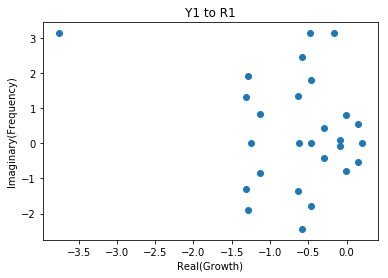

In [38]:
eiglog_Y1_R1=np.log(eig_values_Y1_R1)
plt.scatter(eiglog_Y1_R1.real,eiglog_Y1_R1.imag)
plt.title("Y1 to R1")
plt.xlabel("Real(Growth)")
plt.ylabel("Imaginary(Frequency)")
plt.show()

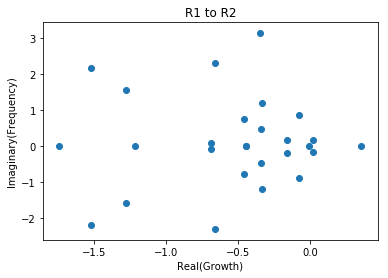

In [39]:
eiglog_R1_R2=np.log(eig_values_R1_R2)
plt.scatter(eiglog_R1_R2.real,eiglog_R1_R2.imag)
plt.title("R1 to R2")
plt.xlabel("Real(Growth)")
plt.ylabel("Imaginary(Frequency)")
plt.show()

In [44]:
lamphi_Y1_R1=np.zeros(eiglog_Y1_R1.shape)

In [45]:
for i in range (27):
    rep=eig_vectors_Y1_R1[i]
    norm=np.linalg.norm(rep)
    val=np.absolute(eig_values_Y1_R1[i])*norm
    lamphi_Y1_R1[i]=val
lamphi_Y1_R1

array([1.77374453, 1.51427514, 1.67417088, 1.25884011, 0.86123907,
       1.08825069, 0.6002364 , 0.47555465, 0.6228062 , 0.77323536,
       0.6925619 , 0.87313469, 0.90873368, 0.50684435, 0.49782629,
       0.88506104, 0.52516242, 0.29597126, 0.16484547, 0.01580301,
       0.14687086, 0.16351229, 0.21844259, 0.20018836, 0.47597678,
       0.34528541, 0.15222055])

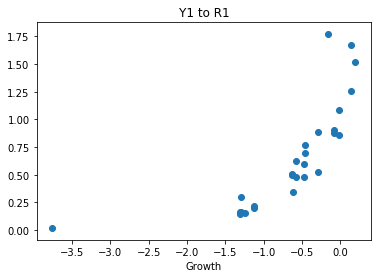

In [46]:
plt.scatter(eiglog_Y1_R1.real,lamphi_Y1_R1)
plt.title("Y1 to R1")
plt.xlabel("Growth")
plt.show()

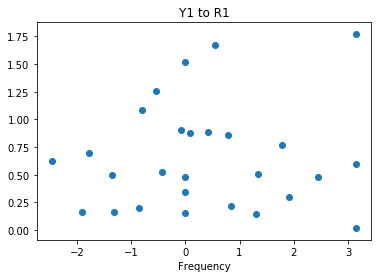

In [47]:
plt.scatter(eiglog_Y1_R1.imag,lamphi_Y1_R1)
plt.title("Y1 to R1")
plt.xlabel("Frequency")
plt.show()

In [48]:
lamphi_R1_R2=np.zeros(27)

In [49]:
for i in range (27):
    rep=eig_vectors_R1_R2[i]
    norm=np.linalg.norm(rep)
    val=np.absolute(eig_values_R1_R2[i])*norm
    lamphi_R1_R2[i]=val
lamphi_R1_R2
    

array([1.04210801, 1.72789724, 0.59191844, 0.46079194, 1.1422726 ,
       0.94711498, 0.65376945, 0.96749736, 0.23442763, 0.22970373,
       0.34368383, 0.24061945, 0.639297  , 0.71501254, 0.82382848,
       1.21942329, 1.1400959 , 0.84140965, 0.70701162, 0.49207056,
       0.63159431, 0.11052328, 0.18167733, 0.27228351, 0.4191182 ,
       0.3622052 , 0.55287826])

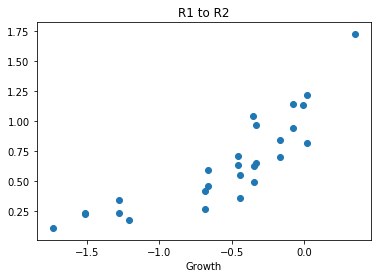

In [50]:
plt.scatter(eiglog_R1_R2.real,lamphi_R1_R2)
plt.title("R1 to R2")
plt.xlabel("Growth")
plt.show()

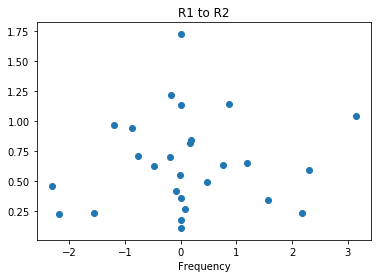

In [51]:
plt.scatter(eiglog_R1_R2.imag,lamphi_R1_R2)
plt.title("R1 to R2")
plt.xlabel("Frequency")
plt.show()

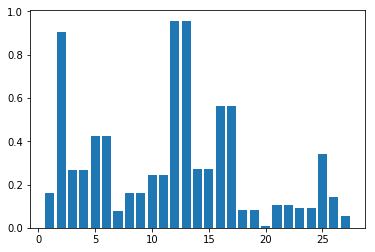

In [52]:
index=np.zeros(27)
weiabs=np.zeros(27)
for i in range (27):
    index[i]=i+1
for j in range (27):
    weiabs[j]=np.absolute(eig_vectors_Y1_R1[0,j])
plt.bar(index,weiabs)
plt.show()

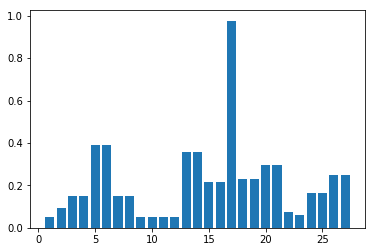

In [53]:
weiabs2=np.zeros(27)
for j in range (27):
    weiabs2[j]=np.absolute(eig_vectors_R1_R2[0,j])
plt.bar(index,weiabs2)
plt.show()